In [9]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import numpy as np
from keras import layers
from keras.layers import Input,Add,Activation,ZeroPadding2D,BatchNormalization,Flatten,Conv2D,AveragePooling2D,MaxPool2D,Dense
from keras.models import Model,load_model
from tensorflow.keras.utils import plot_model
from keras.initializers import glorot_uniform
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import keras.backend as K
import tensorflow as tf

In [2]:
ROWS = 64
COLS = 64
CHANNELS = 3
CLASSES = 2

In [3]:
#read image from file path and resize + interpolate it
# def read_image(file_path):
#   img = cv2.imread(file_path,cv2.IMREAD_COLOR)
#   return cv2.resize(img,(ROWS,COLS),interpolation=cv2.INTER_CUBIC)

# #prepare train data x 
# def prepare_data(images):
#   m=len(images)
#   X=np.zeros((m,ROWS,COLS,CHANNELS),dtype=np.uint8)
#   y=np.zeros((1,m),dtype=np.uint8)
#   for i,image_file in enumerate(images):
#     X[i,:] = read_image(image_file)
#     if 'dog' in image_file.lower():
#       y[0,i] = 1
#     elif 'cat' in image_file.lower():
#       y[0,i] = 0
#   return X,y

# #convert labels to one_hot
# def convert_to_one_hot(Y,C):
#   Y = np.eye(C)[Y.reshape(-1)].T
#   return Y

In [4]:
#data normalization
# TRAIN_DIR = 'Train_data/'
# TEST_DIR = 'Test_data/'

# train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
# test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

# train_set_x,train_set_y = prepare_data(train_images)
# test_set_x,test_set_y = prepare_data(test_images)

# X_train = train_set_x/255
# X_test = test_set_x/255

# Y_train = convert_to_one_hot(train_set_y,CLASSES)
# Y_test = convert_to_one_hot(test_set_y,CLASSES)


In [8]:
#print shapes

In [5]:
#Build residual network identity block
def identity_block(X,f,filters,stage,block):
  conv_name_base = 'res'+str(stage)+block+'_branch'
  bn_name_base = 'bn'+str(stage)+block+'_branch'

  F1,F2,F3 = filters

  #save input value to add in future layers
  X_shortcut = X

  #first component of main path
  X = Conv2D(filters = F1, kernel_size = (1,1),strides = (1,1),padding = 'valid', name = conv_name_base + '2a',kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3,name = bn_name_base + '2a')(X)
  X = Activation('relu')(X)

  #second component of main path
  X = Conv2D(filters = F2, kernel_size = (1,1), strides =(1,1),padding = 'same', name = conv_name_base+'2b', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3,name = bn_name_base+'2b')(X)
  X = Activation('relu')(X)

  #third ciomponenet
  X = Conv2D(filters = F3, kernel_size = (1,1),strides = (1,1),padding = 'valid',name = conv_name_base+'2c',kernel_initializer=glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base+'2c')(X)

  #finale step : add residual value
  X = Add()([X,X_shortcut])
  X = Activation('relu')(X)

  return X




In [6]:
#test with randoom values
tf.compat.v1.reset_default_graph()
with tf.compat.v1.Session() as test:
  A_prev = tf.compat.v1.placeholder("float",[3,4,4,6])
  X = np.random.randn(3,4,4,6)
  A = identity_block(A_prev, f=2 , filters = [2,4,6], stage= 1, block='a')
  test.run(tf.compat.v1.global_variables_initializer())
  out = test.run([A],feed_dict={A_prev: X,K.learning_phase(): 0})
  print("out = ", out[0][1][1][0])

Instructions for updating:
Colocations handled automatically by placer.
out =  [2.4201705 1.4989642 1.0817027 0.        1.415307  1.0688803]


In [7]:
#conv block with residual connection
def convolution_block(X,f,filters,stage,block,s=2):
  #define name basis
  conv_name_base = 'res'+str(stage)+block+'_branch'
  bn_name_base = 'bn' +str(stage)+ block+'_branch'

  #retrive filters
  F1,F2,F3 = filters

  #save for future residual value
  X_shortcut = X

  #first conv component
  X = Conv2D(F1,(1,1),strides=(s,s),name=conv_name_base+'2a',kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3,name = bn_name_base+'2a')(X)
  X = Activation('relu')(X)

  #second component
  X = Conv2D(F2,(f,f),strides=(1,1),padding = 'same', name=conv_name_base+'2b',kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3,name = bn_name_base+'2b')(X)
  X = Activation('relu')(X)

  #third component
  X = Conv2D(F3,(1,1),strides=(1,1),padding = 'valid',name=conv_name_base+'2c',kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3,name = bn_name_base+'2c')(X)

  #shortcut pass
  X_shortcut = Conv2D(F3,(1,1),strides=(s,s),name = conv_name_base+'1',kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
  X_shortcut = BatchNormalization(axis = 3,name = bn_name_base+'1')(X_shortcut)

  #final step : add rediual connection
  X = Add()([X,X_shortcut])
  X = Activation('relu')(X)

  return X
  

In [8]:
#test conv block with random input
tf.compat.v1.reset_default_graph()
with tf.compat.v1.Session() as test:
  A_prev = tf.compat.v1.placeholder("float",[3,4,4,6])
  X = np.random.randn(3,4,4,6)
  A = convolution_block(A_prev, f=2 , filters = [2,4,6], stage= 1, block='a')
  test.run(tf.compat.v1.global_variables_initializer())
  out = test.run([A],feed_dict={A_prev: X,K.learning_phase(): 0})
  print("out = ", out[0][1][1][0])

out =  [0.47759274 0.42007792 0.         1.0488567  0.27902937 0.9230363 ]


In [15]:
from keras.layers.pooling import MaxPooling2D
#now build the residual network
def Resnet50(input_shape = (64,64,3),classes=2):
  X_input = Input(input_shape)

  X = ZeroPadding2D((3,3))(X_input)

  #stage1
  X = Conv2D(64,(7,7),strides=(2,2),name='conv1',kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3,3),strides=(2,2))(X)

  #stage2
  X = convolution_block(X,f=3,filters=[64,64,256],stage=2,block='a',s=1)
  X = identity_block(X,3,[64,64,256],stage=2,block='b')
  X = identity_block(X,3,[64,64,256],stage=2,block='c')

  #stage3
  X = convolution_block(X,f=3,filters=[128,128,512],stage=3,block='a',s=2)
  X = identity_block(X,3,[128,128,512],stage=3,block='b')
  X = identity_block(X,3,[128,128,512],stage=3,block='c')
  X = identity_block(X,3,[128,128,512],stage=3,block='d')

  #stage4
  X = convolution_block(X,f=3,filters=[256,256,1024],stage=4,block='a',s=2)
  X = identity_block(X,3,[256,256,1024],stage=4,block='b')
  X = identity_block(X,3,[256,256,1024],stage=4,block='c')
  X = identity_block(X,3,[256,256,1024],stage=4,block='d')
  X = identity_block(X,3,[256,256,1024],stage=4,block='e')
  X = identity_block(X,3,[256,256,1024],stage=4,block='f')

  #stage5
  X = convolution_block(X,f=3,filters=[512,512,2048],stage=5,block='a',s=2)
  X = identity_block(X,3,[512,512,2048],stage=5,block='b')
  X = identity_block(X,3,[512,512,2048],stage=5,block='c')

  #avg pool
  X = AveragePooling2D((2,2),name='avg_pool')(X)

  #output layer
  X = Flatten()(X)
  X = Dense(classes,activation='softmax',name='fc'+str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

  #create model
  model = Model(inputs=X_input,outputs = X, name='ResNet50')

  return model

In [16]:
model = Resnet50(input_shape=(ROWS,COLS,CHANNELS),classes=CLASSES)

In [17]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
#model.fit(X_train,Y_train,epochs=100,batch_size=64)

In [20]:
#preds = model.evaluate(X_test,Y_test)
#print("Loss = "+str(preds[0]))
#print("Test Accuracy = "+str(preds[1]))

In [21]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 70, 70, 3)   0           ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 32, 32, 64)   9472        ['zero_padding2d_2[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1[0][0]']           

In [23]:
#model.save('ResNet50.h5')

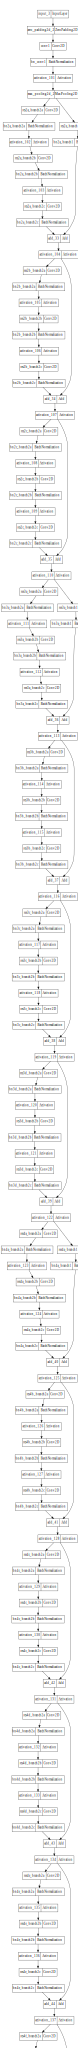

In [24]:
plot_model(model,to_file='model.png')
SVG(model_to_dot(model).create(prog='dot',format='svg'))